In [8]:
pip install twython 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install wordcloud


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from collections import Counter
import re
import string

nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')


import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

In [ ]:
!pip install requests_mock FuzzyTM blosc2 cython
!pip install clyent==1.2.1 python-dateutil==2.8.2 PyYAML==6.0.1 numpy<1.25,>=1.21 black>=22.3.0


Defaulting to user installation because normal site-packages is not writeable


The system cannot find the file specified.


In [ ]:
df = pd.read_csv('news.csv')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
df.columns 

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [ ]:
df1 = df.copy()

In [ ]:
df1.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

df1['label'] = df1['label'].replace('REAL', '0')
df1['label'] = df1['label'].replace('FAKE', '1')
df1['label'] = df1['label'].astype('int32')

df1.drop(columns=['title'], inplace=True)


In [ ]:
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('—', '') 
    text = [word for word in text.split(' ') if word not in stopword]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

df1["clean_text"] = df1["text"].apply(clean)


In [ ]:
df1.drop(columns=['text'], inplace=True)

In [ ]:
df1["word_count"] = df1['clean_text'].str.split().str.len()
df1

,id,label,clean_text,word_count
0,8476,1,daniel greenfield shillman journal fellow free...,692
1,10294,1,googl pinterest digg linkedin reddit stumbleup...,238
2,3608,0,us secretari state john f kerri said monday st...,240
3,10142,1,kayde king kaydeek novemb lesson tonight de...,235
4,875,0,primari day new york frontrunn hillari clinton...,176
...,...,...,...,...
6330,4490,0,state depart told republican nation committe c...,376
6331,8062,1,‘p’ pb stand ‘plutocratic’ ‘pentagon’ post oct...,1312
6332,8622,1,antitrump protest tool oligarchi reform alwa...,1036
6333,4021,0,addi ababa ethiopia presid obama conven meet l...,650


In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df1['score'] = df1['clean_text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['sentiment'] = df1['score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['clean_text', 'score', 'sentiment']].head())

                                          clean_text   score sentiment
0  daniel greenfield shillman journal fellow free... -0.9978  negative
1  googl pinterest digg linkedin reddit stumbleup...  0.4404  positive
2  us secretari state john f kerri said monday st...  0.4404  positive
3   kayde king kaydeek novemb   lesson tonight de...  0.4902  positive
4  primari day new york frontrunn hillari clinton...  0.9765  positive


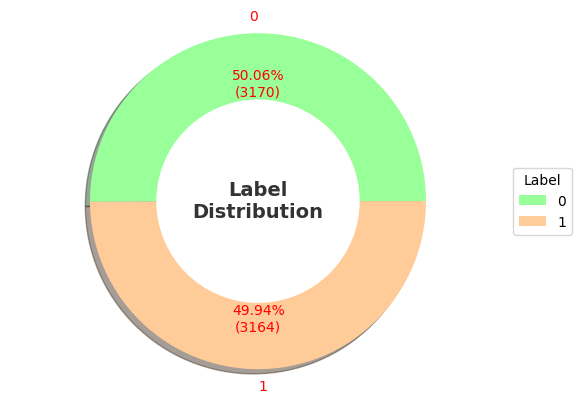

In [ ]:
colors = ['#99ff99', '#ffcc99']

label_counts = df1.groupby("label").size()
explode = [0.0] * len(label_counts)

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=label_counts,  
    labels=label_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(label_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Label\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(label_counts.index, title="Label", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()


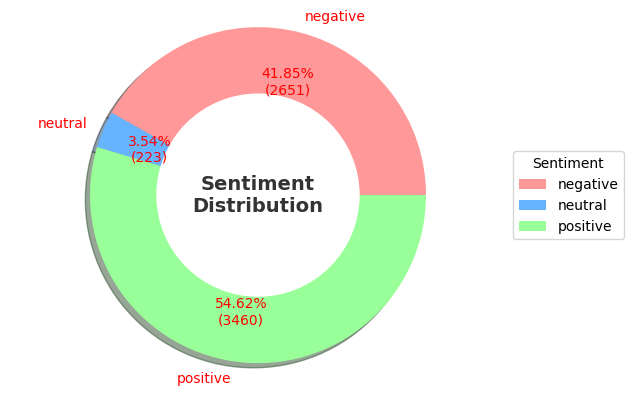

In [ ]:
colors = ['#ff9999', '#66b3ff', '#99ff99']

explode = (0.0, 0, 0)  

sentiment_counts =df1.groupby("sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

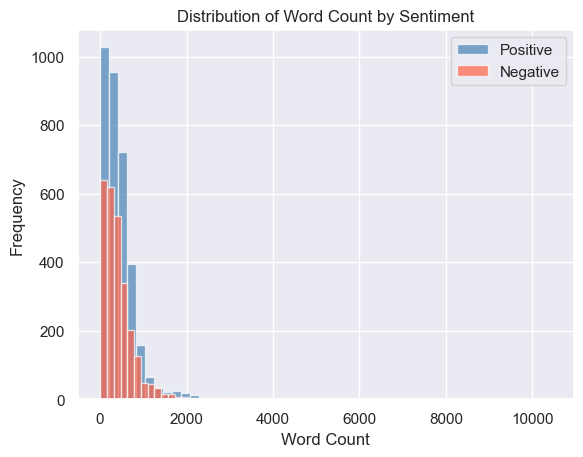

In [ ]:
sns.set(style="darkgrid", palette="muted", color_codes=True)

positive_reviews = df1[df1["sentiment"] == 'positive']  
negative_reviews = df1[df1["sentiment"] == 'negative'] 

sns.distplot(positive_reviews['word_count'], color='steelblue', label='Positive', kde=False, hist_kws={'alpha': 0.7})
sns.distplot(negative_reviews['word_count'], color='tomato', label='Negative', kde=False, hist_kws={'alpha': 0.7})

plt.title('Distribution of Word Count by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [ ]:
df1['temp_list'] = df1['clean_text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Set2')

,Common_words,count
0,said,19020
1,trump,17635
2,clinton,14570
3,state,14156
4,would,12590
5,us,12073
6,one,11005
7,peopl,10917
8,like,9266
9,new,9051


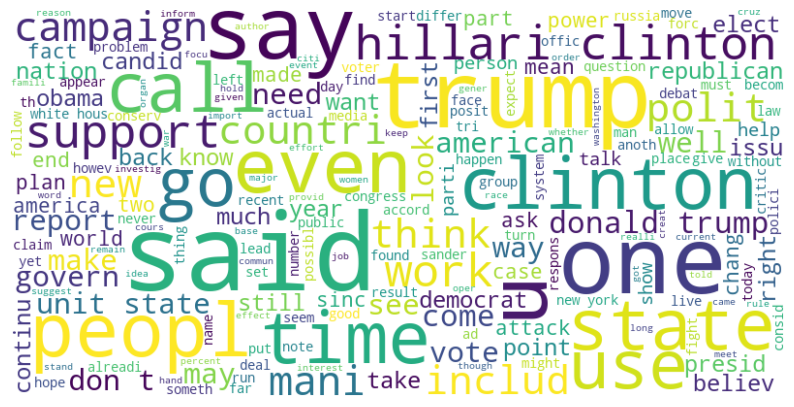

In [ ]:
all_words = ' '.join(df1['clean_text'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(all_words)
                   
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
Positive_sent = df1[df1['sentiment'] == 'positive']
Negative_sent = df1[df1['sentiment'] == 'negative']
Neutral_sent = df1[df1['sentiment'] == 'neutral']

In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

,Common_words,count
0,trump,11956
1,said,10571
2,clinton,9875
3,state,8475
4,would,7578
5,republican,6500
6,one,6445
7,like,6107
8,peopl,6013
9,us,5876


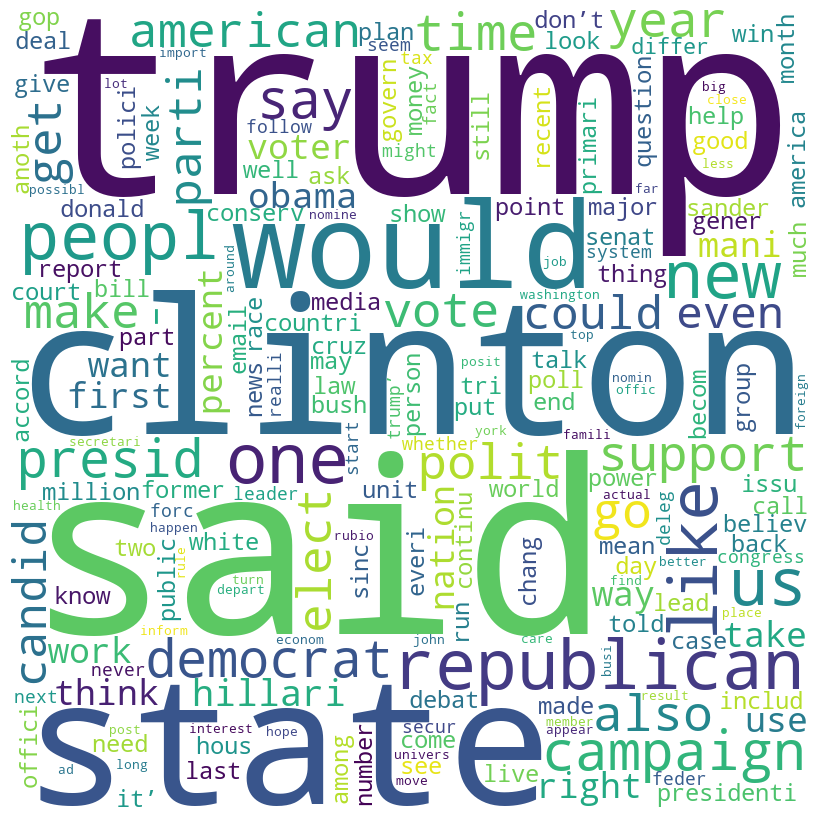

In [ ]:
positive_words = [item for sublist in df1[df1['sentiment'] == 'positive']['temp_list'] for item in sublist]

word_counter = Counter(positive_words)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']), 
                min_font_size = 10).generate_from_frequencies(word_counter)
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()


In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

,Common_words,count
0,clinton,147
1,said,129
2,trump,110
3,presid,80
4,hillari,78
5,would,76
6,vote,75
7,state,73
8,elect,73
9,one,70


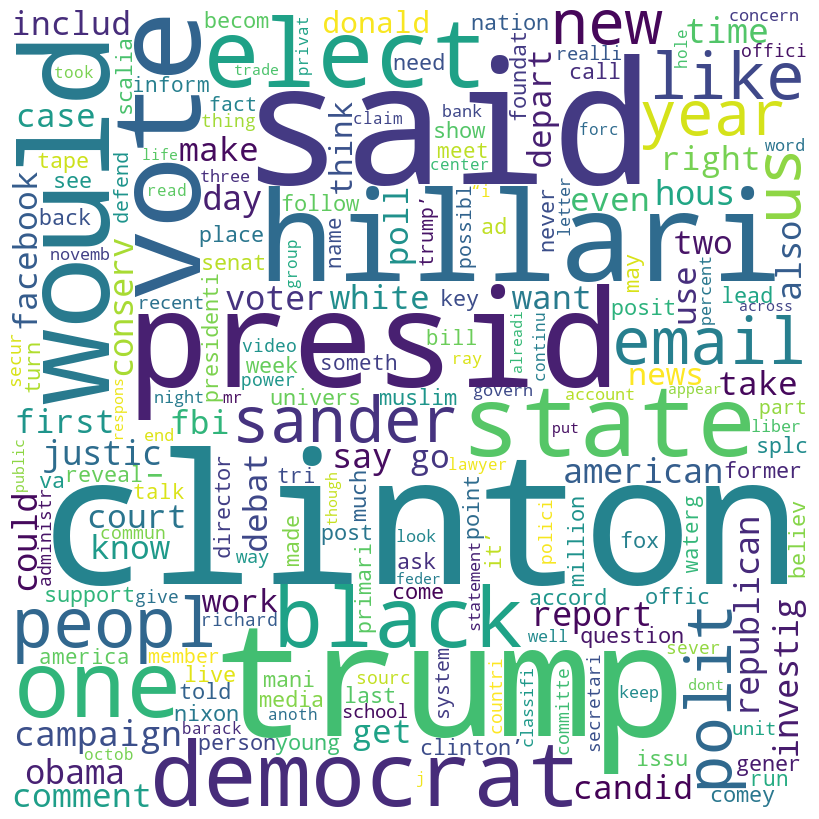

In [ ]:
neutral_words = [item for sublist in df1[df1['sentiment'] == 'neutral']['temp_list'] for item in sublist]

word_counter = Counter(neutral_words)

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']),
                      min_font_size=10).generate_from_frequencies(word_counter)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


In [ ]:
top = Counter([item for sublist in df1[df1['sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Set2')

,Common_words,count
0,said,8320
1,us,6140
2,state,5608
3,trump,5569
4,would,4936
5,peopl,4838
6,clinton,4548
7,one,4490
8,presid,3503
9,say,3405


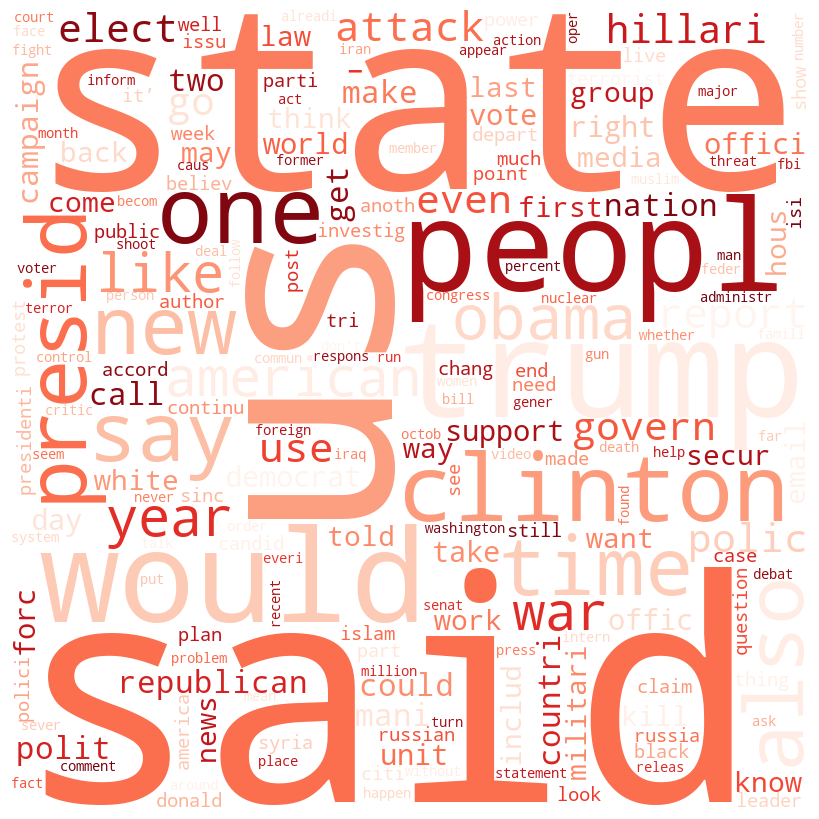

In [ ]:
negative_words = [item for sublist in df1[df1['sentiment'] == 'negative']['temp_list'] for item in sublist]

word_counter = Counter(negative_words)

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=set(['common', 'stopwords', 'you', 'may', 'want', 'to', 'add', 'custom', 'stop', 'words']),
                      min_font_size=10, colormap='Reds').generate_from_frequencies(word_counter)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


Defaulting to user installation because normal site-packages is not writeable
Could not fetch URL https://pypi.org/simple/scikit-learn/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/scikit-learn/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)'))) - skipping
Could not fetch URL https://pypi.org/simple/imbalanced-learn/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/imbalanced-learn/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)'))) - skipping


In [ ]:
df2 = df1.copy()

In [ ]:
X = df2['clean_text'].values
y = df2['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_pa = make_imb_pipeline(TfidfVectorizer(), SMOTE(random_state=42), PassiveAggressiveClassifier())

In [ ]:
model_pa.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('passiveaggressiveclassifier', PassiveAggressiveClassifier())])

In [ ]:
y_pred = model_pa.predict(X_test)

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [ ]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

Test Set Results:
Accuracy: 0.9384372533543804
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       639
           1       0.94      0.93      0.94       628

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



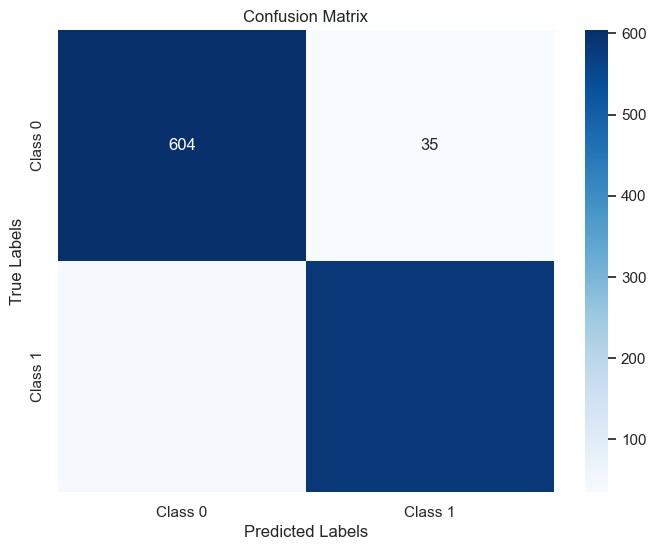

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()